# Hands-on: Mapping poverty data

[**Michele Tizzoni** (@mtizzoni)](https://twitter.com/mtizzoni), <michele.tizzoni@isi.it>

[**Daniela Paolotti** (@danielapaolotti)](https://twitter.com/danielapaolotti), <daniela.paolotti@isi.it>

In this notebook we show how to deal with spatial data with Python with a specific focus on:
* loading and visualizing spatial data
* creating a map for a generic indicator at country level
* visualizing shapefiles

<h1> Outline </h1>
    
1. Introduction: issue of using multiple datasets
   
2. Download/upload data

3. Data Cleaning

4. Data Processing

5. Data Analysis and Visualization

In [2]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# 1. Countries in the world

In this study, we use several different data sources (e.g. World Bank, SDGs, FAO, etc) and each of them has different data format, thus we need to know <i>a priori</i> which countries to consider in our analysis.   

Some examples:

* <b>MACROAREA and/or REGIONS</b>:

    e.g. Arab World, Central Europe and the Baltics, Early demographic dividend, Europe & Central Asia, etc.


* <b>DEPENDENT TERRITORIES</b>: 

    e.g. British Virgin Islands is a British Overseas Territory, Faroe Islands belongs to the Kingdom of Denmark, etc.


* <b>Not UN member state or Special Administrative Region</b>: 

    e.g. Kosovo is not a UN member state, Hong Kong SAR (China) is a Special Administrative Region of the People's Republic of China, etc.
    
<p>&nbsp;</p>    
Here we use as a reference the list of countries reported on Wikipedia:

<i> There are 195 countries in the world today. This total comprises 193 countries that are member states of the United Nations and 2 countries that are non-member observer states: the Holy See and the State of Palestine. </i> 

Source: https://en.wikipedia.org/wiki/List_of_sovereign_states

In [3]:
# in the following there's the code showing how to extract the table from Wikipedia
# or you can skip this part and upload the file "list_countries.csv" 

<b> upload the table from Wikipedia

In [4]:
url = "https://en.wikipedia.org/wiki/List_of_sovereign_states"
list_tables = pd.read_html(url, flavor='bs4') 

In [5]:
# we are interested in the first table in the Wikipedia page
df_countries = list_tables[0]
df_countries.head()

Common and formal names  \
0                                            NaN   
1       ↓ UN member states and observer states ↓   
2                            Abkhazia → Abkhazia   
3  Afghanistan – Islamic Republic of Afghanistan   
4                  Albania – Republic of Albania   

  Membership within the UN System[a] Sovereignty dispute[b]  \
0                                NaN                    NaN   
1                                NaN                    NaN   
2                                NaN                    NaN   
3                    UN member state                   None   
4                    UN member state                   None   

  Further information on status and recognition of sovereignty[d]  
0                                                NaN               
1                                                NaN               
2                                                NaN               
3                                                NaN               
4                                                NaN

In [6]:
# some cleaning :

In [7]:
# keep only first 2 columns of the table
df_countries = df_countries[df_countries.columns[:2]]
df_countries.columns = ['Country name', 'UN membership']

In [8]:
# drop nan values
# and select only those countries that are "UN member state" or "UN observer state" (i.e. Palestine and Vatican City)
df_countries = df_countries.dropna(subset=['UN membership'])
df_countries = df_countries[(df_countries['UN membership'].str.contains('UN member state')) | 
                            (df_countries['UN membership'].str.contains('UN observer state'))].reset_index(drop=True)

In [9]:
# print number of countries
print( df_countries.shape[0], 'countries' )

195 countries


In [10]:
# the column of Country name contains both common and formal name; split it into 2 columns
df_countries['Short name'], df_countries['Long name'] = df_countries['Country name'].str.split("–").str

In [11]:
# remove any special characters and/or footnotes between []
df_countries['Short name'] = df_countries['Short name'].str.strip().str.replace(r"\[.*\]","")
df_countries['Long name'] = df_countries['Long name'].str.strip().str.replace(r"\[.*\]","")

In [12]:
# write to file
# df_countries[['Short name','Long name','UN membership']].to_csv("../spatial/list_countries.csv", index=False)

<b> or skip the code above and upload the csv file 

In [13]:
df_countries = pd.read_csv("../spatial/list_countries.csv")

In [14]:
print( len(df_countries['Short name'].unique()), "countries" )

195 countries


# 2. Map country names correctly

Example:

<i>The <b>Democratic Republic of the Congo</b>, is also known as <b>DR Congo</b>, the <b>DRC</b>, <b>DROC</b>, <b>Congo Kinshasa</b> or simply <b>the Congo</b>.</i> 

Source: https://en.wikipedia.org/wiki/Democratic_Republic_of_the_Congo

Other names found in the various datasets : 

- Congo
- The Congo
- Congo, The
- Congo, Rep.
- Congo, Dem. Rep.
- Congo, DR
- Congo (Democratic Republic of the)
- Congo (Kinshasa)
- Congo Brazzaville
- ...

In [15]:
# let's look for Congo in our dataframe 
df_countries[df_countries['Short name'].str.contains('Congo')]

Short name Long name    UN membership
38  Congo, Democratic Republic of the       NaN  UN member state
39             Congo, Republic of the       NaN  UN member state

How to solve it:

Manually build a dictionary that maps the name of countries correctly

In [16]:
# for example:
fix_countryname = {"Congo, Dem. Rep.": "Democratic Republic of the Congo", 
                   "Congo, Dem Republic": "Democratic Republic of the Congo",
                   "Congo (Democratic Republic of the)": "Democratic Republic of the Congo",
                   "Congo, Democratic Republic of the": "Democratic Republic of the Congo",
                   "Congo, Democratic Republic of": "Democratic Republic of the Congo",
                   "Congo, DR": "Democratic Republic of the Congo",
                   "Congo (Kinshasa)": "Democratic Republic of the Congo"}

In [17]:
# upload the file 
fix_countryname = dict()
with open("../spatial/fix_countries_name.txt", 'r') as fin:
    for line in fin:
        item1, item2 = line.strip().split('|')
        fix_countryname[item1] = item2

In [18]:
# make a list of countries
list_countries = df_countries['Short name'].replace(fix_countryname).unique()

In [19]:
# display the countries on a map

In [20]:
# upload shapefile
shp = gpd.read_file("../spatial/shapefile/ne_50m_admin_0_countries.shp")

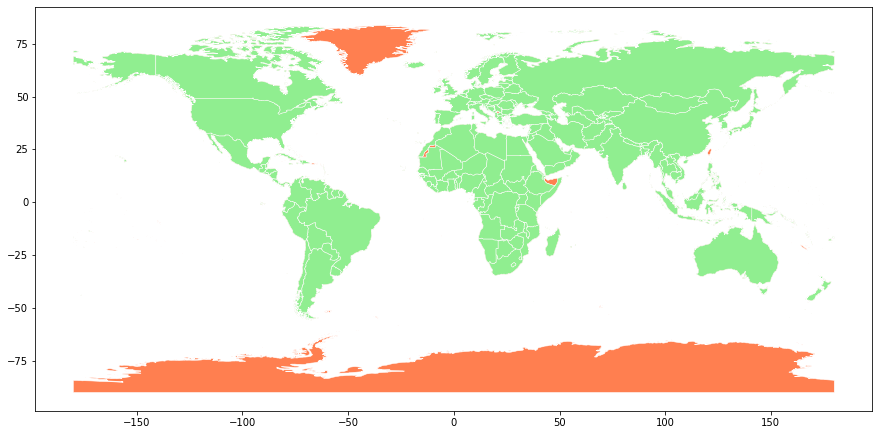

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_aspect('equal'); #ax.axis('off')
shp.plot(ax=ax, color="coral", ec='w', lw=0.5) 
shp[shp.ADMIN.isin(list_countries)].plot(ax=ax, color='lightgreen', ec='w', lw=0.5)
plt.show()

In [22]:
# print the remaining countries (i.e. the countries in red)
shp[~shp.ADMIN.isin(list_countries)].sort_values('ADMIN').ADMIN.unique()

array(['Aland', 'American Samoa', 'Anguilla', 'Antarctica', 'Aruba',
       'Ashmore and Cartier Islands', 'Bermuda',
       'British Indian Ocean Territory', 'British Virgin Islands',
       'Cayman Islands', 'Cook Islands', 'Curacao', 'Falkland Islands',
       'Faroe Islands', 'French Polynesia',
       'French Southern and Antarctic Lands', 'Greenland', 'Guam',
       'Guernsey', 'Heard Island and McDonald Islands',
       'Hong Kong S.A.R.', 'Indian Ocean Territories', 'Isle of Man',
       'Jersey', 'Kosovo', 'Macao S.A.R', 'Montserrat', 'New Caledonia',
       'Niue', 'Norfolk Island', 'Northern Cyprus',
       'Northern Mariana Islands', 'Pitcairn Islands', 'Puerto Rico',
       'Saint Barthelemy', 'Saint Helena', 'Saint Martin',
       'Saint Pierre and Miquelon', 'Siachen Glacier', 'Sint Maarten',
       'Somaliland', 'South Georgia and the Islands', 'Taiwan',
       'Turks and Caicos Islands', 'United States Virgin Islands',
       'Wallis and Futuna', 'Western Sahara'], dty

# 3. Data: Population living in poverty 

There exists different ways to <b>distinguish the poor and the non-poor</b> according to a threshold, i.e. <b><i>poverty line</i></b>, generally defined as the per-capita monetary requirements an individual needs to afford the purchase of a basic bundle of goods and services.

The <b>World Bank</b> provides data for 4 different thresholds (referring to the 2011 international prices):

- international poverty line at US$\$$1.90 a day ( that is the \% of the population living with LESS than $\$$1.90 per day )
    
- international poverty line at US$\$$3.20 a day 

- international poverty line at US$\$$5.50 a day 

- national poverty line (country-specific)

Source: World Bank, Poverty indicator (https://data.worldbank.org/indicator/)

In [23]:
# upload datasets
data = pd.read_csv("../data/API_WorldBank_population_poverty_thresholds.csv", encoding="utf-8")

In [24]:
data.head()

Country Name Country Code  \
0        Aruba          ABW   
1        Aruba          ABW   
2        Aruba          ABW   
3        Aruba          ABW   
4  Afghanistan          AFG   

                                      Indicator Name Indicator Code  1960  \
0  Poverty headcount ratio at $5.50 a day (2011 P...    SI.POV.UMIC   NaN   
1  Poverty headcount ratio at national poverty li...    SI.POV.NAHC   NaN   
2  Poverty headcount ratio at $3.20 a day (2011 P...    SI.POV.LMIC   NaN   
3  Poverty headcount ratio at $1.90 a day (2011 P...    SI.POV.DDAY   NaN   
4  Poverty headcount ratio at $5.50 a day (2011 P...    SI.POV.UMIC   NaN   

   1961  1962  1963  1964  1965  ...  2009  2010  2011  2012  2013  2014  \
0   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
4   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   

   2015  2016  2017  2018  
0   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN  
4   NaN   NaN   NaN   NaN  

[5 rows x 63 columns]

In [25]:
# print indicators in the dataframe
data['Indicator Name'].unique()

array(['Poverty headcount ratio at $5.50 a day (2011 PPP) (% of population)',
       'Poverty headcount ratio at national poverty lines (% of population)',
       'Poverty headcount ratio at $3.20 a day (2011 PPP) (% of population)',
       'Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)'],
      dtype=object)

## Data Cleaning

In [26]:
# reduce length of names by removing the text between ()
data['Indicator Name'] = data['Indicator Name'].str.replace(r" \(.*\)","")

In [27]:
indicators = sorted(data['Indicator Name'].unique())
indicators

['Poverty headcount ratio at $1.90 a day',
 'Poverty headcount ratio at $3.20 a day',
 'Poverty headcount ratio at $5.50 a day',
 'Poverty headcount ratio at national poverty lines']

In [28]:
# drop 2 columns
data.drop(['Country Code','Indicator Code'], axis=1, inplace=True)

In [29]:
# num. of countries per indicator
data.groupby('Indicator Name')['Country Name'].size()

Indicator Name
Poverty headcount ratio at $1.90 a day               264
Poverty headcount ratio at $3.20 a day               264
Poverty headcount ratio at $5.50 a day               264
Poverty headcount ratio at national poverty lines    264
Name: Country Name, dtype: int64

#### Map the name of the countries and remove additional regions

In [30]:
# fix name of the countries
data['Country Name'].replace(fix_countryname, inplace=True)

In [31]:
# check the remaining countries. There are macroarea, regions, dependent territories, etc.
data[~data['Country Name'].isin(list_countries)]['Country Name'].sort_values().unique()

array(['American Samoa', 'Arab World', 'Aruba', 'Bermuda',
       'British Virgin Islands', 'Caribbean small states',
       'Cayman Islands', 'Central Europe and the Baltics',
       'Channel Islands', 'Curacao', 'Early-demographic dividend',
       'East Asia & Pacific',
       'East Asia & Pacific (IDA & IBRD countries)',
       'East Asia & Pacific (excluding high income)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (IDA & IBRD countries)',
       'Europe & Central Asia (excluding high income)', 'European Union',
       'Faroe Islands', 'Fragile and conflict affected situations',
       'French Polynesia', 'Gibraltar', 'Greenland', 'Guam',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'Hong Kong SAR, China', 'IBRD only', 'IDA & IBRD total',
       'IDA blend', 'IDA only', 'IDA total', 'Isle of Man', 'Kosovo',
       'Late-demographic dividend', 'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high inc

In [32]:
# remove them from the dataframe
data = data[data['Country Name'].isin(list_countries)]

In [33]:
# check againg the num. of countries per indicator
data.groupby('Indicator Name')['Country Name'].size()

Indicator Name
Poverty headcount ratio at $1.90 a day               194
Poverty headcount ratio at $3.20 a day               194
Poverty headcount ratio at $5.50 a day               194
Poverty headcount ratio at national poverty lines    194
Name: Country Name, dtype: int64

In [34]:
# the time window goes from 1960 to 2018, but there's no data for some years up to 1977
data[data.columns[data.isnull().all()]].columns

Index(['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1978'],
      dtype='object')

In [35]:
# drop those NaN values
data = data[data.columns[~data.isnull().all()] ]

# Data Processing

The number of countries per indicator changes over time

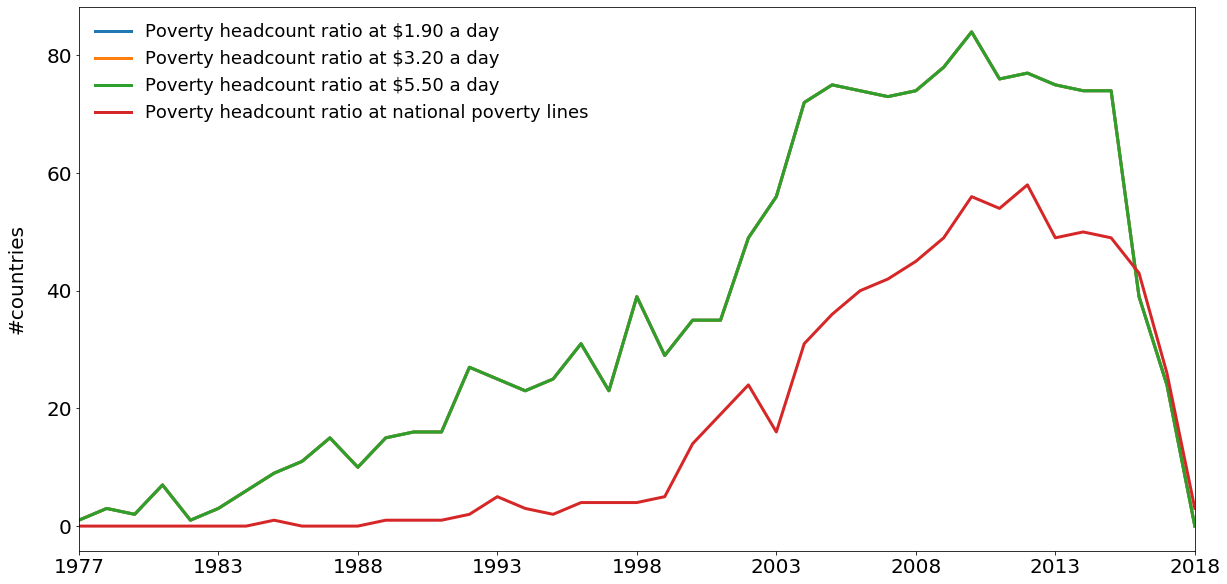

In [36]:
# distribution of the num. of countries per year per indicator
data.groupby('Indicator Name').count().drop(['Country Name'], axis=1).T.plot(figsize=(20,10), lw=3, fontsize=20)
plt.ylabel('#countries', fontsize=20, labelpad=20);
plt.legend(loc='upper left', fontsize=18, frameon=False); plt.show()

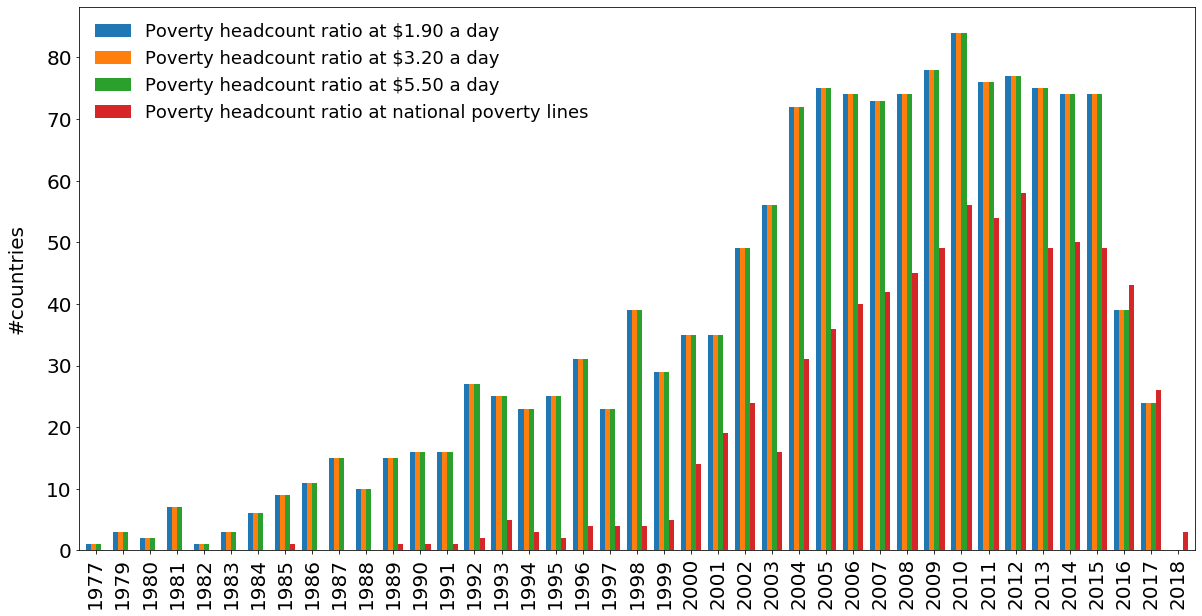

In [37]:
# distribution of the num. of countries per year per indicator
data.groupby('Indicator Name').count().drop(['Country Name'], axis=1).T.plot(kind='bar', figsize=(20,10), width=0.75, fontsize=20)
plt.ylabel('#countries', fontsize=20, labelpad=20);
plt.legend(loc='upper left', fontsize=18, frameon=False); plt.show()

#### For each country, we consider the most recent data available so that we are able to capture a more complete picture of the various indicators. Then, the final EJ index will be updated as soon as new data is released.

In [38]:
# build a datframe containing country, indicator and most recent year available
tmp = data.set_index(['Country Name','Indicator Name']).stack().reset_index()
tmp.columns = ['Country Name', 'Indicator Name', 'TimePeriod', 'Value']
country_year = tmp.groupby(['Country Name','Indicator Name'])['TimePeriod'].max().reset_index(name='TimePeriod')
country_year.head()

Country Name                                     Indicator Name TimePeriod
0  Afghanistan  Poverty headcount ratio at national poverty lines       2016
1      Albania             Poverty headcount ratio at $1.90 a day       2012
2      Albania             Poverty headcount ratio at $3.20 a day       2012
3      Albania             Poverty headcount ratio at $5.50 a day       2012
4      Albania  Poverty headcount ratio at national poverty lines       2012

In [39]:
# then select only those years
data_filtered = country_year.merge(tmp, on=['Country Name','Indicator Name','TimePeriod'], how='inner')
data_filtered.head()

Country Name                                     Indicator Name TimePeriod  \
0  Afghanistan  Poverty headcount ratio at national poverty lines       2016   
1      Albania             Poverty headcount ratio at $1.90 a day       2012   
2      Albania             Poverty headcount ratio at $3.20 a day       2012   
3      Albania             Poverty headcount ratio at $5.50 a day       2012   
4      Albania  Poverty headcount ratio at national poverty lines       2012   

   Value  
0   54.5  
1    1.1  
2    7.7  
3   39.1  
4   14.3

## Analysis

In [40]:
# time period per indicator
data_filtered.groupby('Indicator Name')['TimePeriod'].agg(['min','max'])

min   max
Indicator Name                                               
Poverty headcount ratio at $1.90 a day             1992  2017
Poverty headcount ratio at $3.20 a day             1992  2017
Poverty headcount ratio at $5.50 a day             1992  2017
Poverty headcount ratio at national poverty lines  1993  2018

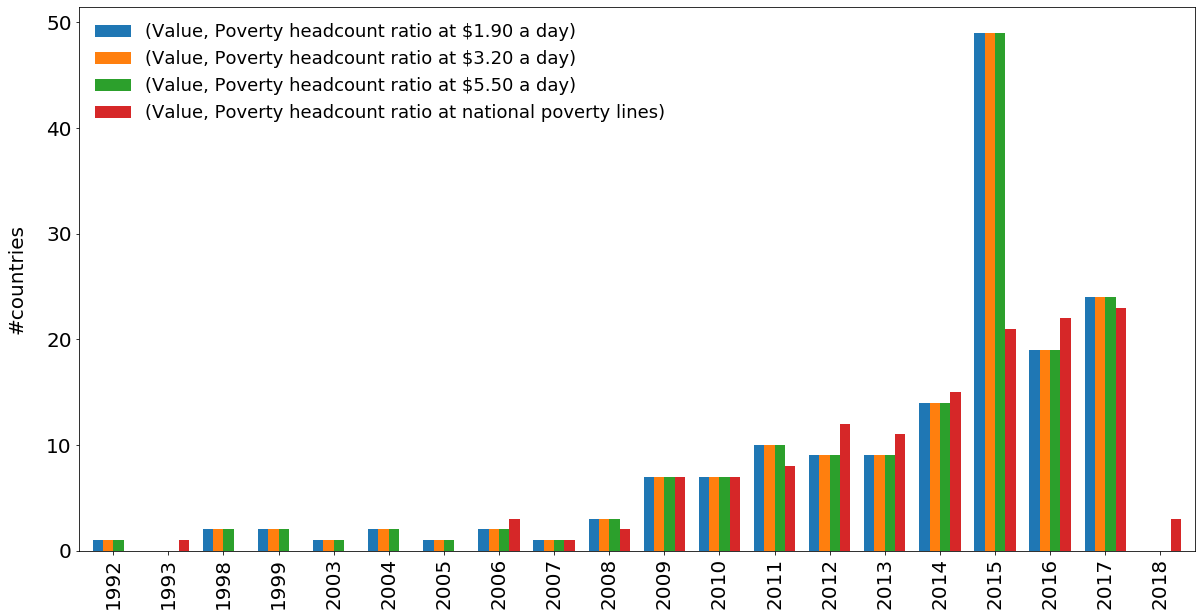

In [41]:
# distribution of the num of countries per year
data_filtered.groupby(['TimePeriod','Indicator Name']).count().drop('Country Name', axis=1).unstack().plot(kind='bar', figsize=(20,10), width=0.75, fontsize=20)
plt.xlabel(''); plt.ylabel('#countries', fontsize=20, labelpad=20)
plt.legend(loc='upper left', fontsize=18, frameon=False); 
plt.show()

In [42]:
# some statistics
data_filtered.groupby('Indicator Name').describe().round(2)

Value                     \
                                                   count   mean    std  min   
Indicator Name                                                                
Poverty headcount ratio at $1.90 a day             163.0  14.14  20.21  0.0   
Poverty headcount ratio at $3.20 a day             163.0  26.54  29.41  0.0   
Poverty headcount ratio at $5.50 a day             163.0  42.04  35.08  0.0   
Poverty headcount ratio at national poverty lines  136.0  30.69  18.41  0.4   

                                                                              
                                                     25%    50%    75%   max  
Indicator Name                                                                
Poverty headcount ratio at $1.90 a day              0.50   3.20  21.30  77.6  
Poverty headcount ratio at $3.20 a day              1.20  11.80  50.80  91.0  
Poverty headcount ratio at $5.50 a day              5.95  34.80  79.15  97.7  
Poverty headcount ratio at national poverty lines  18.60  25.65  42.70  82.3

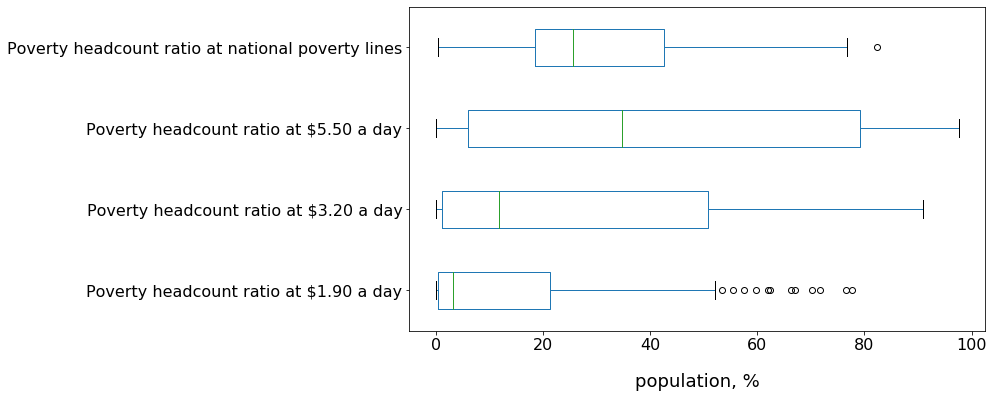

In [43]:
# boxplot
data_filtered.boxplot(by='Indicator Name', column='Value', vert=False, grid=False, fontsize=16, figsize=(10,6));
plt.suptitle(''); plt.title(''); plt.xlabel('population, %', fontsize=18, labelpad=20)
plt.show()

In [44]:
# maybe of interest 
#import seaborn as sns
#sns.pairplot(data_filtered.pivot('Country Name','Indicator Name','Value'))

In [45]:
# correlation
data_filtered.pivot('Country Name','Indicator Name','Value').corr(method='spearman')

Indicator Name                                     Poverty headcount ratio at $1.90 a day  \
Indicator Name                                                                              
Poverty headcount ratio at $1.90 a day                                           1.000000   
Poverty headcount ratio at $3.20 a day                                           0.977022   
Poverty headcount ratio at $5.50 a day                                           0.933133   
Poverty headcount ratio at national poverty lines                                0.728439   

Indicator Name                                     Poverty headcount ratio at $3.20 a day  \
Indicator Name                                                                              
Poverty headcount ratio at $1.90 a day                                           0.977022   
Poverty headcount ratio at $3.20 a day                                           1.000000   
Poverty headcount ratio at $5.50 a day                                           0.981676   
Poverty headcount ratio at national poverty lines                                0.698449   

Indicator Name                                     Poverty headcount ratio at $5.50 a day  \
Indicator Name                                                                              
Poverty headcount ratio at $1.90 a day                                           0.933133   
Poverty headcount ratio at $3.20 a day                                           0.981676   
Poverty headcount ratio at $5.50 a day                                           1.000000   
Poverty headcount ratio at national poverty lines                                0.651887   

Indicator Name                                     Poverty headcount ratio at national poverty lines  
Indicator Name                                                                                        
Poverty headcount ratio at $1.90 a day                                                      0.728439  
Poverty headcount ratio at $3.20 a day                                                      0.698449  
Poverty headcount ratio at $5.50 a day                                                      0.651887  
Poverty headcount ratio at national poverty lines                                           1.000000

In [46]:
# maps

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

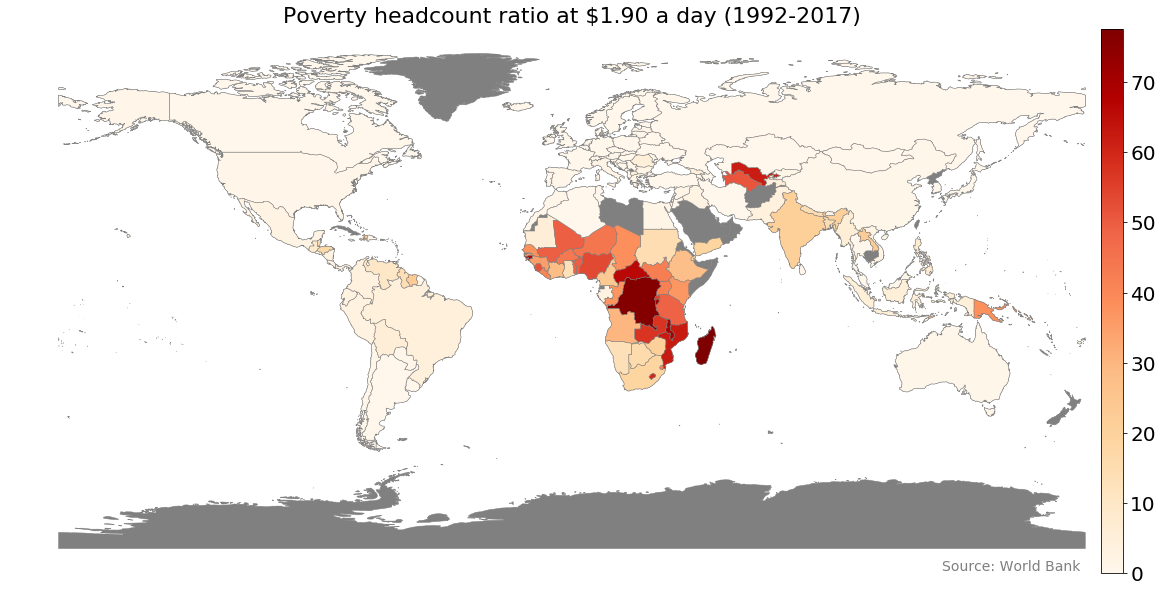

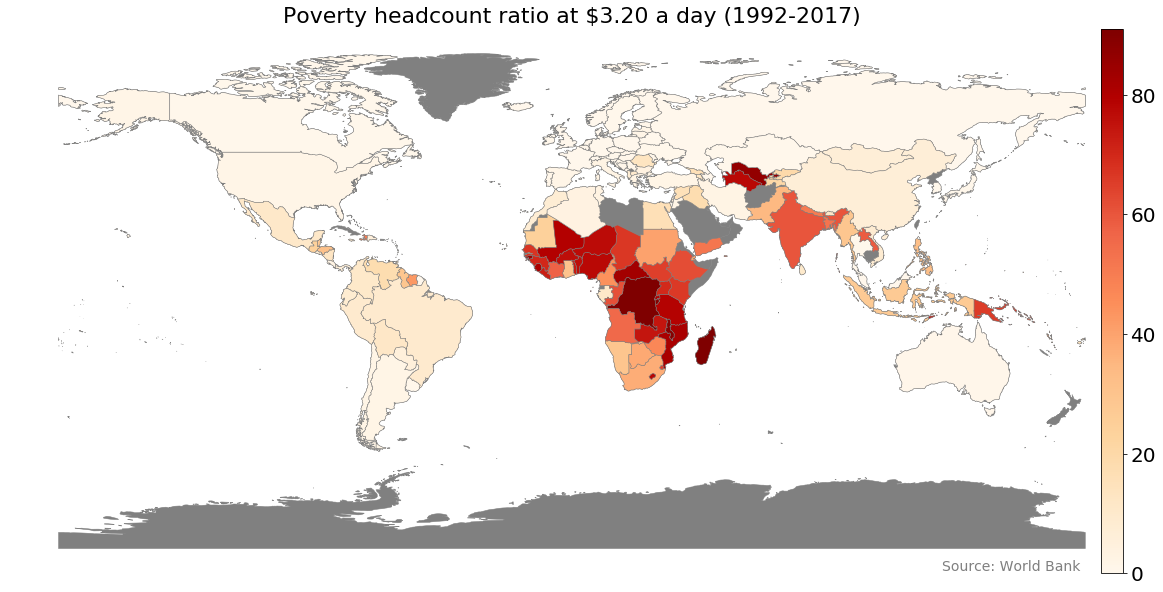

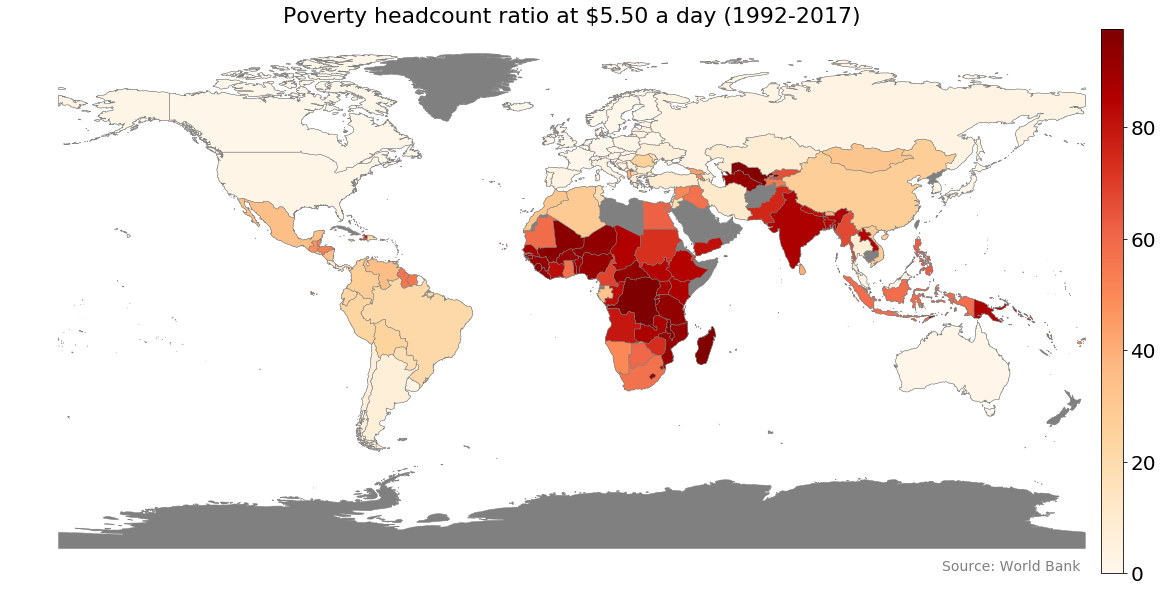

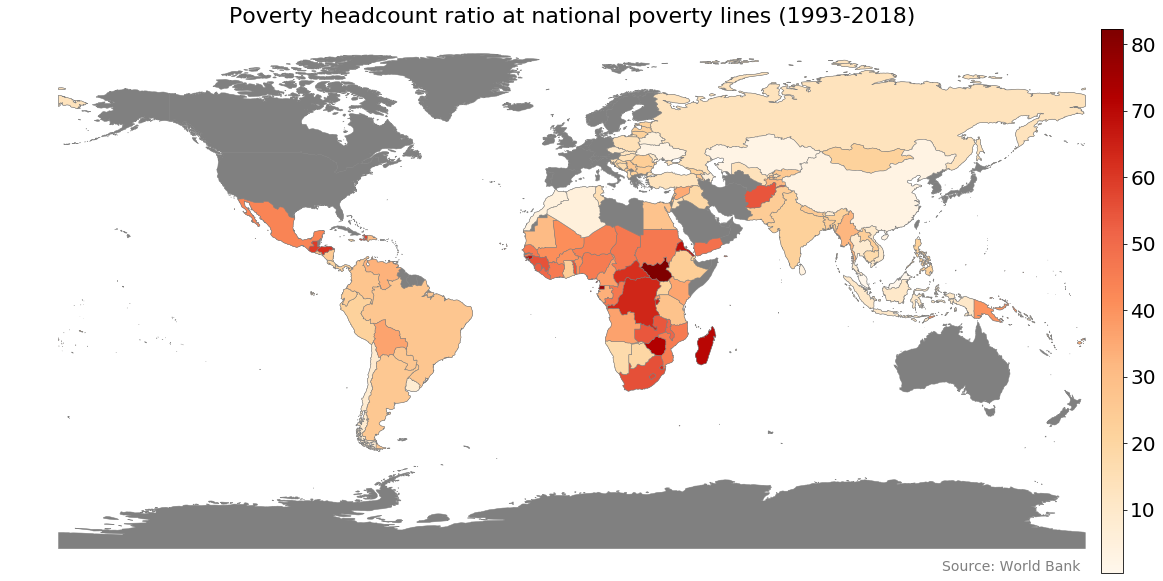

In [49]:
for ix in indicators:
    subset = data_filtered[data_filtered['Indicator Name']==ix].reset_index(drop=True)
    time_window = subset['TimePeriod'].min() +'-'+ subset['TimePeriod'].max()
    df_maps = shp.merge(subset[['Country Name','Value']], left_on='ADMIN', right_on='Country Name', how='inner')
  
    fig, ax = plt.subplots( figsize=(20,20))
    ax.set_aspect('equal'); ax.axis('off')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=-0.5)
    cax.tick_params(labelsize=20)
    shp.plot(ax=ax, color="grey", ec='grey', lw=0.5) 
    df_maps.plot(ax=ax, column='Value', cmap='OrRd', ec='grey', lw=0.5,
                 legend=True, legend_kwds={"label": "Population, %"}, cax=cax)

    ax.set_title(ix+' ('+time_window+')', fontsize=22)
    ax.annotate("Source: World Bank", xy=(0.95, 0.025), xycoords="axes fraction", ha="right", va="top", fontsize=14, color='grey')
    plt.show() 